In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd #pip installed
import matplotlib.pyplot as plt 

In [2]:
# Parameters to explore
year= '2019-2021'# 2018
unit = 'tonnes'
products = ['Palm oil','Apples','Cane sugar, non-centrifugal']
key_wanted = [tuple([product, unit]) for product in products]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

data = pd.read_pickle('../Data/Data_year_groups_12.pkl')

#data = pd.read_pickle('../Data/Trade_geo.pkl')
country_metadata = pd.read_pickle('../Data/Country_info.pkl')
shape_file = pd.read_pickle('../Data/Shapefile_with_positions.pkl')

data=data.rename(columns={'destin_country_ISO':'origin_country_ISO','destin_country':'origin_country','origin_country_ISO':'destin_country_ISO','origin_country':'destin_country'})
data

# Filter year to explore in data:
data_filtered = data.loc[data.year==year,:]

year_country_list = set(data_filtered.origin_country_ISO.unique()).union(data_filtered.destin_country_ISO.unique())
country_metadata_filt = country_metadata.loc[country_metadata['ISO'].isin(year_country_list),:]


# Get node dictionary (only for nodes existing in this year) used by networkx: 
def Make_nx_graph (data_filtered, country_metadata_filt,key_wanted):
    pos_dict = country_metadata_filt.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    data_g = data_filtered.groupby(['item','unit'])

    # Filter by the key we want
    data_net=data_g.get_group(key_wanted) #

    edges = data_net.loc[:,['origin_country_ISO','destin_country_ISO','value']]

    # Get edge list for networkx
    edge_list= list(edges.to_records(index=False))

    # Create network
    G=nx.DiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_weighted_edges_from(edge_list)
    node_list=list(G.nodes())
    G_plot= G.copy()

    # Remove countries without geometry position (only for plotting reasons)
    no_geometry = list(country_metadata_filt.loc[country_metadata_filt['pos'].isnull(),'ISO'].values)

    G_plot.remove_nodes_from(no_geometry)

    country_metadata_filt = country_metadata_filt.loc[~country_metadata_filt.ISO.isin(no_geometry),:]
    pos_dict2 = dict(zip(country_metadata_filt.ISO, country_metadata_filt.pos))

    # Remove nodes with 0 weight
    to_remove = [(u, v, data) for u, v, data in G_plot.edges(data=True) if 'weight' in data and data['weight'] == 0]
    G_plot.remove_edges_from(to_remove)
    return G_plot, pos_dict2

G1, pos =  Make_nx_graph (data_filtered, country_metadata_filt,key_wanted[0])
G2, _=  Make_nx_graph (data_filtered, country_metadata_filt,key_wanted[1])
G3,_ =  Make_nx_graph (data_filtered, country_metadata_filt,key_wanted[2])


graphs = [G1,G2,G1]

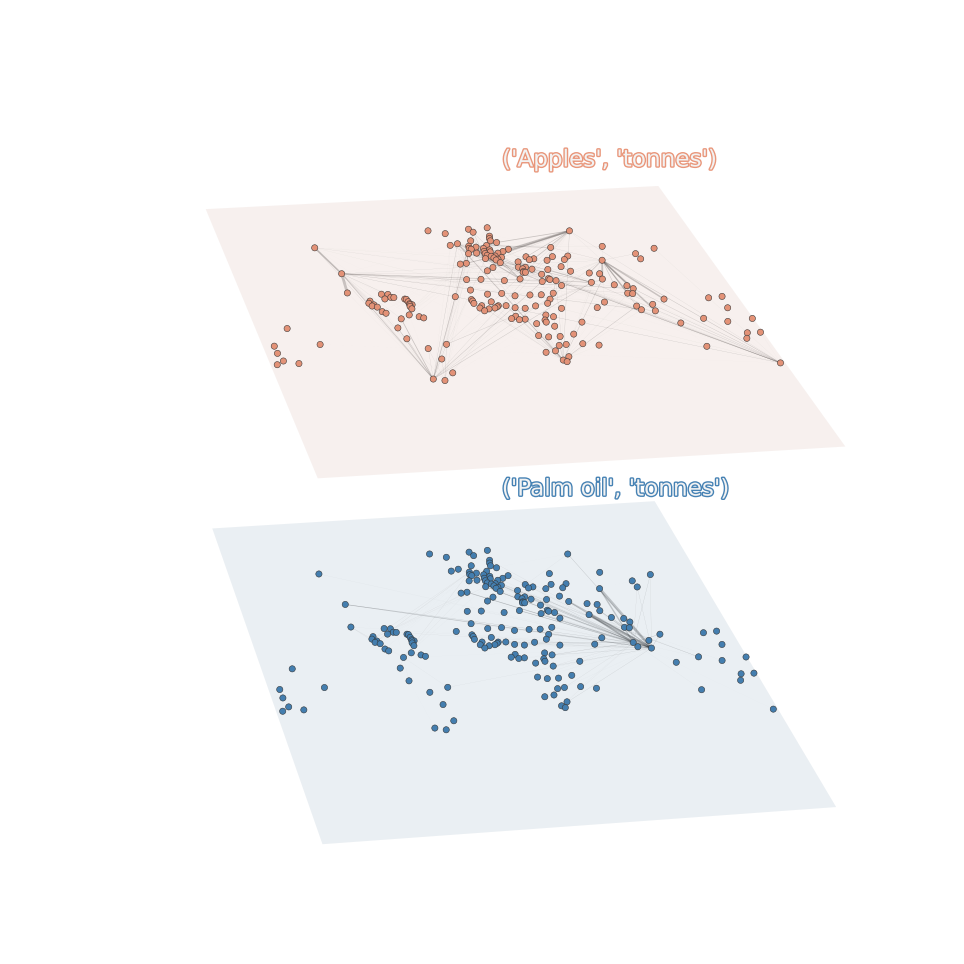

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection


graphs = [G1, G2]
w = 8
h = 6

cols = ['steelblue', 'darksalmon','crimson']
#plot_prova = shape_file.plot(figsize=(15, 10),edgecolor='black', linewidth=0.5)#facecolor='white',

fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})

for gi, G in enumerate(graphs):
    # node positions
    xs = list(list(zip(*list(pos.values())))[0])
    ys = list(list(zip(*list(pos.values())))[1])
    zs = [gi]*len(xs) # set a common z-position of the nodes 
#    map_lines = Line3DCollection(full_outline.geoms, zorder=gi, color='.5',
#                                         alpha=0.4, linestyle='--', linewidth=1)

#    ax.add_collection3d(map_lines)
    a=shape_file.dissolve()
    b=a.boundary.explode(index_parts=True)

    # node colors
    cs = [cols[gi]]*len(xs)
    
    # if you want to have between-layer connections
    '''
    if gi > 0:
        thru_nodes = np.random.choice(list(G.nodes()),10,replace=False)
        lines3d_between = [(list(pos[i])+[gi-1],list(pos[i])+[gi]) for i in thru_nodes]
        between_lines = Line3DCollection(lines3d_between, zorder=gi, color='.5',
                                         alpha=0.4, linestyle='--', linewidth=1)
        ax.add_collection3d(between_lines)
    '''
    # add within-layer edges 
    lines3d = [(list(pos[i])+[gi],list(pos[j])+[gi]) for i,j in G.edges()]
    weights= list(nx.get_edge_attributes(G,'weight').values())
    weights=weights/max(weights)

    line_collection = Line3DCollection(lines3d, zorder=gi, color='black',linewidths=weights, alpha=0.2)#cols[gi]
    ax.add_collection3d(line_collection)

    # now add nodes
    ax.scatter(xs, ys, zs ,s=5, c=cs,linewidths=0.2,edgecolors='.2', alpha=1, zorder=gi+1) #marker='s',edgecolors='.1',

    # add a plane to designate the layer
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = -90 #min(ys)-ydiff*0.1
    ymax = 90 #max(ys)+ydiff*0.1
    xmin = -180 #min(xs)-xdiff*0.1 * (w/h)
    xmax = 180 #max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    # add label
    layertext = ax.text(-0.0, 1.15, gi*0.95+0.5, key_wanted[gi],
                        color='.95', fontsize='small', zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=1, foreground=cols[gi]),
                                      path_effects.Normal()])

# set them all at the same x,y,zlims
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(graphs) - 1 + 0.1)

# select viewing angle
angle = 260
height_angle = 20
rot= 0
ax.view_init(height_angle, angle,rot)

# how much do you want to zoom into the fig
ax.dist = 9

ax.set_axis_off()

# plt.savefig('multilayer_network.png',dpi=425,bbox_inches='tight')
plt.show()

In [ ]:
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt

r2 = sg.box(0.5,0.5,1.5,1.5)
r3 = sg.box(4,4,5,5)

new_shape = so.unary_union(shape_file.geometry)
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')


plt.show()

In [ ]:
    map_lines = Line3DCollection(full_outline.geoms, zorder=gi, color='.5',
                                         alpha=0.4, linestyle='--', linewidth=1)

    ax.add_collection3d(map_lines)
    plt.show()

In [ ]:
bound= shape_file['geometry'].boundary


# Combine the individual boundaries into a single geometry
full_outline = unary_union(bound)
type(unary_union(full_outline))
full_outline

In [ ]:
unary_union(full_outline).plot()


full_outline.geoms
#lines3d_between = [(list(pos[i])+[gi-1],list(pos[i])+[gi]) for i in thru_nodes]


In [ ]:
weights= list(nx.get_edge_attributes(G,'weight').values())
weights=weights/max(weights)

In [ ]:
a.geometry

In [ ]:
a=shape_file.dissolve()
b=a.boundary.explode(index_parts=True)


prova=pd.DataFrame(b.loc[0,0].coords.xy, index=['x','y']).T

#ax.scatter(b.loc[0,0].coords.xy[0],b.loc[0,0].coords.xy[1], [gi]*len(b.loc[0,0].coords.xy[1]))

prova['level']=1
prova=prova.values().to_list()

map3d = [(list(prova.x,prova.y)+[gi],list(pos[j])+[gi])+[gi] for i in prova]
list(pos[i])

In [ ]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from numpy import asarray, concatenate, ones


def PolygonPatch(polygon, **kwargs):

    def coding(ob):
        # The codes will be all "LINETO" commands, except for "MOVETO"s at the
        # beginning of each subpath
        n = len(getattr(ob, 'coords', None) or ob)
        vals = np.ones(n, dtype=Path.code_type) * Path.LINETO
        vals[0] = Path.MOVETO
        return vals

    vertices = np.concatenate(
        [np.asarray(polygon.exterior)[:, :2]] +
        [np.asarray(r)[:, :2] for r in polygon.interiors])
    codes = np.concatenate(
        [coding(polygon.exterior)] + [coding(r) for r in polygon.interiors])

    return PathPatch(Path(vertices, codes), **kwargs)

PolygonPatch(shape_file['geometry'])

In [ ]:
new_shape= so.unary_union(shape_file['geometry'].geoms)
from descartes import PolygonPatch
import matplotlib.pyplot as plt
BLUE = '#6699cc'
GRAY = '#999999'
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(new_shape, fc=GRAY, ec=BLUE, alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()
